In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.afw.coord
import lsst.afw.geom

In [3]:
import lsst.daf.persistence
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"
DATA_DIR_UNDITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-undithered/"
DATA_DIR_PHOSIM = "/global/cscratch1/sd/descdm/DC1/DC1-phoSim-3a/"

I call the butler to get the data

In [4]:
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)
butler2 = lsst.daf.persistence.Butler(DATA_DIR_PHOSIM)

In [ ]:
skymap = butler.get("deepCoadd_skyMap")

In [ ]:
skymap_phosim = butler2.get("deepCoadd_skyMap")

In [ ]:
tract = skymap.generateTract(0)

In [ ]:
tract_phosim = skymap_phosim.generateTract(0)

In [ ]:
print tract_phosim.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(93.0*np.pi/180),lsst.afw.geom.Angle(-29.0*np.pi/180)))
print tract.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(93.0*np.pi/180),lsst.afw.geom.Angle(-29.0*np.pi/180)))

In [ ]:
print butler.getKeys("deepCoadd_ref")
print butler.getKeys("deepCoadd_calexp")
print butler.getKeys("deepCoadd_meas")
print butler.getKeys("calexp")

In [5]:
exposure_imsim = butler.get("deepCoadd_calexp", filter='r', patch='17,13', tract=0, immediate=True)

In [13]:
catalog_imsim = butler.get("deepCoadd_ref", patch='17,13', tract=0, immediate=True)

In [6]:
exposure_phosim = butler2.get("deepCoadd_calexp", filter='r', patch='15,13', tract=0, immediate=True)

In [ ]:
catalog_phosim = butler2.get("deepCoadd_ref", patch='15,13', tract=0, immediate=True)

In [23]:
catalog_imsim.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="merge_footprint_i", doc="Detection footprint overlapped with a detection from filter i"), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="merge_footprint_r", doc="Detection footprint overlapped with a detection from filter r"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="merge_footprint_z", doc="Detection footprint overlapped with a detection from filter z"), Key['Flag'](offset=32, bit=3)),
    (Field['Flag'](name="merge_footpri

In [ ]:
sel_imsim = np.logical_and(catalog_imsim.get("detect_isPrimary"),catalog_imsim.get("base_ClassificationExtendedness_value")==1)

In [ ]:
sel_phosim = np.logical_and(catalog_phosim.get("detect_isPrimary"),catalog_phosim.get("base_ClassificationExtendedness_value")==1)

In [ ]:
print len(catalog_imsim), np.count_nonzero(sel_imsim), 1.0*np.count_nonzero(sel_imsim)/len(sel_imsim)

In [ ]:
print len(catalog_phosim), np.count_nonzero(sel_phosim), 1.0*np.count_nonzero(sel_phosim)/len(sel_phosim)

In [ ]:
calib = exposure_imsim.getCalib()
calib.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMag, psfMagErr = calib.getMagnitude(catalog_imsim.getPsfFlux(), catalog_imsim.getPsfFluxErr())
CModelMag, CModelMagErr = calib.getMagnitude(catalog_imsim.get("modelfit_CModel_flux"), catalog_imsim.get("modelfit_CModel_fluxSigma"))

In [ ]:
calibp = exposure_phosim.getCalib()
calibp.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMagp, psfMagErrp = calibp.getMagnitude(catalog_phosim.getPsfFlux(), catalog_phosim.getPsfFluxErr())
CModelMagp, CModelMagErrp = calibp.getMagnitude(catalog_phosim.get("modelfit_CModel_flux"), catalog_phosim.get("modelfit_CModel_fluxSigma"))

In [ ]:
print calib.getFluxMag0()
print calibp.getFluxMag0()

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

In [ ]:
plt.scatter(CModelMag[sel_imsim],psfMag[sel_imsim],marker='.')
plt.xlim(15,30)
plt.ylim(15,30)
plt.xlabel('CModelMag')
plt.ylabel('psfMag')

In [ ]:
plt.scatter(CModelMagp[sel_phosim],psfMagp[sel_phosim],marker='.')
plt.xlim(15,30)
plt.ylim(15,30)
plt.xlabel('CModelMag')
plt.ylabel('psfMag')

In [ ]:
plt.hist2d(catalog_imsim.get("coord_ra")[sel_imsim]*180/np.pi,catalog_imsim.get("coord_dec")[sel_imsim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]],vmin=0,vmax=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

In [ ]:
plt.hist2d(catalog_phosim.get("coord_ra")[sel_phosim]*180/np.pi,catalog_phosim.get("coord_dec")[sel_phosim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]],vmin=0,vmax=200)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

In [ ]:
plt.hist(catalog_imsim.get("ext_shapeHSM_HsmShapeRegauss_e1")[sel_imsim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{1}$",normed=True)
plt.hist(catalog_imsim.get("ext_shapeHSM_HsmShapeRegauss_e2")[sel_imsim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{2}$",normed=True)
plt.legend(loc="best")
plt.xlabel(r"$e_{i}$")

In [ ]:
plt.hist(catalog_phosim.get("ext_shapeHSM_HsmShapeRegauss_e1")[sel_phosim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{1}$",normed=True)
plt.hist(catalog_phosim.get("ext_shapeHSM_HsmShapeRegauss_e2")[sel_phosim],bins=50,range=(-1.1,1.1),histtype="step",label=r"$e_{2}$",normed=True)
plt.legend(loc="best")
plt.xlabel(r"$e_{i}$")

In [ ]:
reg_imsim = np.logical_and(catalog_imsim.get("coord_ra")*180/np.pi>=92.9,catalog_imsim.get("coord_ra")*180/np.pi<=93.1)
reg_imsim2 = np.logical_and(catalog_imsim.get("coord_dec")*180/np.pi>=-29.0,catalog_imsim.get("coord_dec")*180/np.pi<=-28.8)
sel_imsim_patch = np.logical_and(sel_imsim,reg_imsim)
sel_imsim_patch = np.logical_and(sel_imsim_patch,reg_imsim2)

In [ ]:
reg_phosim = np.logical_and(catalog_phosim.get("coord_ra")*180/np.pi>=92.9,catalog_phosim.get("coord_ra")*180/np.pi<=93.1)
reg_phosim2 = np.logical_and(catalog_phosim.get("coord_dec")*180/np.pi>=-29.0,catalog_phosim.get("coord_dec")*180/np.pi<=-28.8)
sel_phosim_patch = np.logical_and(sel_phosim,reg_phosim)
sel_phosim_patch = np.logical_and(sel_phosim_patch,reg_phosim2)

In [ ]:
print np.count_nonzero(sel_imsim_patch), np.count_nonzero(sel_phosim_patch)

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim_patch],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim_patch],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

In [ ]:
H, xedges, yedges = np.histogram2d(catalog_imsim.get("coord_ra")[sel_imsim]*180/np.pi,catalog_imsim.get("coord_dec")[sel_imsim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]])
H2, xedges, yedges = np.histogram2d(catalog_phosim.get("coord_ra")[sel_phosim]*180/np.pi,catalog_phosim.get("coord_dec")[sel_phosim]*180/np.pi,range=[[92.9,93.1],[-29.0,-28.8]])


In [ ]:
plt.plot(H.flatten()/H2.flatten())

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim_patch],range=(15,30),bins=60,weights=np.ones(np.count_nonzero(sel_imsim_patch))/np.count_nonzero(sel_imsim_patch),histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag[sel_imsim_patch],range=(15,30),bins=60,weights=np.ones(np.count_nonzero(sel_imsim_patch))/np.count_nonzero(sel_imsim_patch),histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim_patch],range=(15,30),bins=60,weights=np.ones(np.count_nonzero(sel_phosim_patch))/np.count_nonzero(sel_phosim_patch),histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp[sel_phosim_patch],range=(15,30),bins=60,weights=np.ones(np.count_nonzero(sel_phosim_patch))/np.count_nonzero(sel_phosim_patch),histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
plt.ylim(0,0.15)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

# Check the outer part

In [ ]:
print tract.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(96.0*np.pi/180),lsst.afw.geom.Angle(-31.5*np.pi/180)))
print tract.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(100.0*np.pi/180),lsst.afw.geom.Angle(-34.0*np.pi/180)))
print tract_phosim.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(96.0*np.pi/180),lsst.afw.geom.Angle(-31.5*np.pi/180)))
print tract_phosim.findPatch(lsst.afw.coord.Coord(lsst.afw.geom.Angle(100.0*np.pi/180),lsst.afw.geom.Angle(-33.0*np.pi/180)))

In [ ]:
catalog_imsim_edge = butler.get("deepCoadd_ref", patch='13,9', tract=0, immediate=True)
#catalog_imsim_out = butler.get("deepCoadd_ref", patch='7,4', tract=0, immediate=True)
catalog_phosim_edge = butler2.get("deepCoadd_ref", patch='10,8', tract=0, immediate=True)
catalog_phosim_out = butler2.get("deepCoadd_ref", patch='4,5', tract=0, immediate=True)

In [ ]:
exposure_imsim_edge = butler.get("deepCoadd_calexp", filter='r', patch='13,9', tract=0, immediate=True)
exposure_phosim_edge = butler2.get("deepCoadd_calexp", filter='r', patch='10,8', tract=0, immediate=True)
exposure_phosim_out = butler2.get("deepCoadd_calexp", filter='r', patch='4,5', tract=0, immediate=True)

In [ ]:
plt.hist2d(catalog_phosim_edge.get("coord_ra")*180/np.pi,catalog_phosim_edge.get("coord_dec")*180/np.pi)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

In [ ]:
plt.hist2d(catalog_imsim_edge.get("coord_ra")*180/np.pi,catalog_imsim_edge.get("coord_dec")*180/np.pi)
plt.xlabel('RA [degrees]')
plt.ylabel('Dec [degrees]')
plt.colorbar()

In [ ]:
racut = np.logical_and(catalog_imsim_edge.get("coord_ra")*180/np.pi>=95.8,catalog_imsim_edge.get("coord_ra")*180/np.pi<=96.0)
deccut = np.logical_and(catalog_imsim_edge.get("coord_dec")*180/np.pi>=-31.5,catalog_imsim_edge.get("coord_dec")*180/np.pi<=-31.3)

In [ ]:
racutp = np.logical_and(catalog_phosim_edge.get("coord_ra")*180/np.pi>=95.8,catalog_phosim_edge.get("coord_ra")*180/np.pi<=96.0)
deccutp = np.logical_and(catalog_phosim_edge.get("coord_dec")*180/np.pi>=-31.5,catalog_phosim_edge.get("coord_dec")*180/np.pi<=-31.3)

In [ ]:
radeccut = np.logical_and(racut,deccut)
radeccutp = np.logical_and(racutp,deccutp)

In [ ]:
calib_edge = exposure_imsim_edge.getCalib()
calib_edge.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMag_edge, psfMagErr_edge = calib_edge.getMagnitude(catalog_imsim_edge.getPsfFlux(), catalog_imsim_edge.getPsfFluxErr())

In [ ]:
calibp_edge = exposure_phosim_edge.getCalib()
calibp_edge.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMagp_edge, psfMagErrp_edge = calibp_edge.getMagnitude(catalog_phosim_edge.getPsfFlux(), catalog_phosim_edge.getPsfFluxErr())

In [ ]:
calib_out = exposure_phosim_out.getCalib()
calib_out.setThrowOnNegativeFlux(False)  # don't raise an exception when we encounter a negative or NaN flux
psfMagp_out, psfMagErrp_out = calib_out.getMagnitude(catalog_phosim_out.getPsfFlux(), catalog_phosim_out.getPsfFluxErr())

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(psfMag_edge[radeccut],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim edge')
plt.hist(psfMagp_edge[radeccutp],range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim edge')
plt.hist(psfMagp_out,range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-PhoSim out')
#plt.hist(psfMag,range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-imSim center')
#plt.hist(psfMagp,range=(15,30),bins=60,normed=True,histtype='step',label='psfMag-phoSim center')
plt.legend(loc=2)
plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

# Check stars

In [ ]:
sel_imsim = np.logical_and(catalog_imsim.get("deblend_nChild")==0,catalog_imsim.get("deblend_masked")==False)
sel_imsim = np.logical_and(sel_imsim,catalog_imsim.get("detect_isPatchInner"))
sel_imsim = np.logical_and(sel_imsim,catalog_imsim.get("base_ClassificationExtendedness_value")==0)
sel_phosim = np.logical_and(catalog_phosim.get("deblend_nChild")==0,catalog_phosim.get("deblend_masked")==False)
sel_phosim = np.logical_and(sel_phosim,catalog_phosim.get("detect_isPatchInner"))
sel_phosim = np.logical_and(sel_phosim,catalog_phosim.get("base_ClassificationExtendedness_value")==0)
reg_imsim = np.logical_and(catalog_imsim.get("coord_ra")*180/np.pi>=92.9,catalog_imsim.get("coord_ra")*180/np.pi<=93.1)
reg_imsim2 = np.logical_and(catalog_imsim.get("coord_dec")*180/np.pi>=-29.0,catalog_imsim.get("coord_dec")*180/np.pi<=-28.8)
sel_imsim_patch = np.logical_and(sel_imsim,reg_imsim)
sel_imsim_patch = np.logical_and(sel_imsim_patch,reg_imsim2)
reg_phosim = np.logical_and(catalog_phosim.get("coord_ra")*180/np.pi>=92.9,catalog_phosim.get("coord_ra")*180/np.pi<=93.1)
reg_phosim2 = np.logical_and(catalog_phosim.get("coord_dec")*180/np.pi>=-29.0,catalog_phosim.get("coord_dec")*180/np.pi<=-28.8)
sel_phosim_patch = np.logical_and(sel_phosim,reg_phosim)
sel_phosim_patch = np.logical_and(sel_phosim_patch,reg_phosim2)
sel_phosim_patch = np.logical_and(catalog_phosim.get("base_ClassificationExtendedness_value")==0,sel_phosim_patch)
sel_imsim_patch = np.logical_and(catalog_imsim.get("base_ClassificationExtendedness_value")==0,sel_imsim_patch)
plt.figure(figsize=(8,6))
plt.hist(psfMag[sel_imsim_patch],range=(15,30),bins=60,histtype='step',label='psfMag-imSim')
#plt.hist(CModelMag,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-imSim')
plt.hist(psfMagp[sel_phosim_patch],range=(15,30),bins=60,histtype='step',label='psfMag-PhoSim')
#plt.hist(CModelMagp,range=(15,30),bins=60,normed=True,histtype='step',label='CModelMag-PhoSim')
plt.legend(loc=2)
#plt.ylim(0,0.5)
plt.xlabel(r'r$_{ab}$')
plt.ylabel(r'$N(r)$')

# Check background

In [ ]:
#Function from Paul Price (slack desc-ssim)
def getCoaddInputs(butler, dataId, dataset="deepCoadd_calexp"):
    """Get the input dataIds for the nominated coadd

    Parameters
    ----------
    butler : `lsst.daf.persistence.Butler`
        Data butler.
    dataId : `dict`
        Data identifier for the coadd of interest, e.g.,
        `{'tract': 123, 'patch': '4,5', 'filter': 'x'}`.
    dataset : `str`
        Coadd dataset name.

    Returns
    -------
    result : `dict` of `dict`
        Mapping from CCD identifier to a data identifier with 'visit'
        and 'ccd', for each CCD contributing to the coadd.
    """
    coadd = butler.get(dataset, dataId)
    inputs = coadd.getInfo().getCoaddInputs().ccds
    idList = inputs["id"]
    visitList = inputs["visit"]
    ccdList = inputs["ccd"]
    return {ident: {'visit': visit, 'ccd': ccd} for ident, visit, ccd in zip(idList, visitList, ccdList)}

In [ ]:
idlist_phosim = getCoaddInputs(butler2,{'tract': 0, 'patch': '15,13', 'filter': 'r'})

In [ ]:
bg_phosim = butler2.get("calexpBackground",{'ccd': 3202, 'visit': 1789357, 'filter':'r', 'raft':'1,1', 'sensor':'1,1'},immediate=True)

In [ ]:
bg_imsim = butler.get("calexpBackground",{'ccd': 201, 'visit': 2220560, 'filter':'r', 'raft':'1,1', 'sensor':'1,1'},immediate=True)

In [ ]:
idlist_imsim = getCoaddInputs(butler,{'tract': 0, 'patch': '17,13', 'filter': 'r'})

In [ ]:
plt.hist(bg_imsim.getImage().getArray().flatten(),histtype='step',normed=True,label='imSim bkg-counts')
plt.hist(bg_phosim.getImage().getArray().flatten(),histtype='step',normed=True, label='phoSim bkg-counts')
plt.legend()
plt.xlabel('Bkg counts')

# Check images with ginga

In [7]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

In [8]:
afwDisplay.setDefaultBackend("ginga")
afwDisplay.Display.delAllDisplays()

In [9]:
disp = afwDisplay.Display(1, open=False, canvas_type='png')

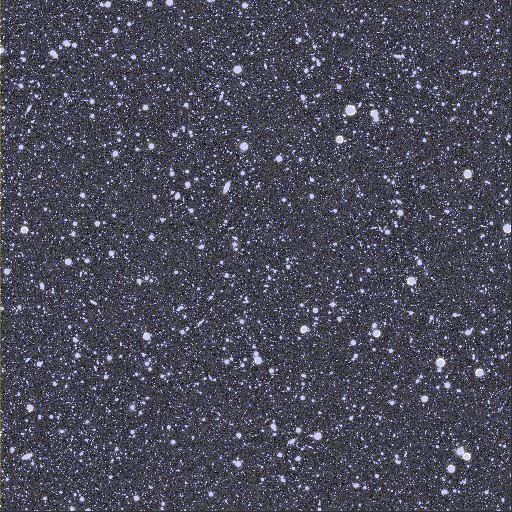

In [40]:
disp.setMaskTransparency(80)
disp.mtv(exposure_imsim)
disp.get_viewer().embed()
disp.show()

In [32]:
x = catalog_imsim.get("base_SdssCentroid_x")
y = catalog_imsim.get("base_SdssCentroid_y")

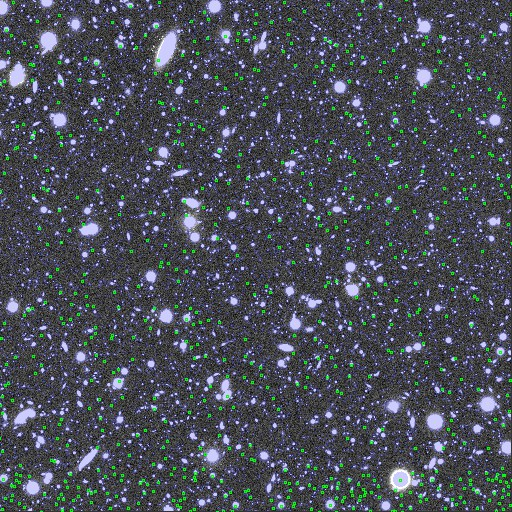

In [47]:
for i in range(len(x))[::20]:
    disp.dot('o',x[i],y[i],ctype=afwDisplay.GREEN)
disp.show()

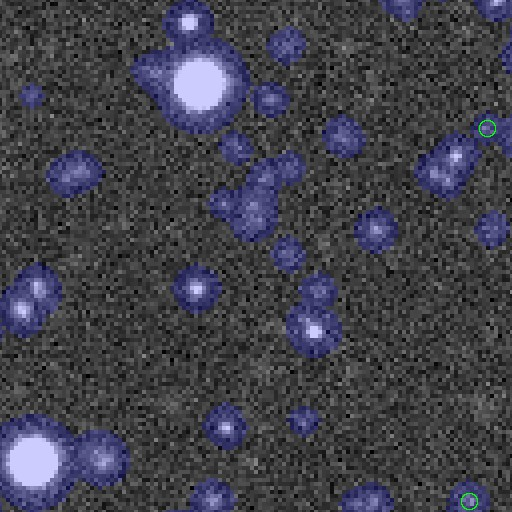

In [48]:
disp.zoom(4)
disp.show()